# A notebook on predicting glass properties from compositions

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#======Loading Dataset ======
raw_data = pd.read_excel('dataGFA.xlsx', sheet_name='rawbased')
print(raw_data.shape)
raw_data.head()

(441, 5)


,Alloy,D,Tg,Tx,Tl
0,Ti50Cu42.5Ni7.5,0.2,670.0,708.0,1226.0
1,Zr70Al8Cu19Ni3,0.2,630.0,689.0,1200.0
2,Zr70Al8Cu3Ni19,0.2,640.0,710.0,1220.0
3,Ag46.2Mg15.4Ca38.4,0.3,407.0,439.0,809.0
4,Ag53.8Mg7.7Ca30.8Cu7.7,0.3,428.0,488.0,843.0


### Sanity check on elem_prop

In [4]:
import re
def check_elem_is_covered(one_alloy):
    parsed_alloy = re.findall(r'([A-Z][a-z]*)(\d*\.\d+|\d+)', one_alloy)
    elements = [comp[0] for comp in parsed_alloy]
    return all(elem in elem_prop for elem in elements)
df=raw_data['Alloy'].apply(check_elem_is_covered)   
##df[~df].index
df.all()

True

### Calculating Features

#### 1. Total Electronegativity (TEN)

In [5]:
def calc_TEN(alloy):
    parsed_alloy=re.findall(r'([A-Z][a-z]*)(\d*\.\d+|\d+)', alloy)
    comps = [{comp[0]: float(comp[1])} for comp in parsed_alloy]
    res = 0
    for comp in comps:
        for k, v in comp.items():
            res += v*elem_prop[k]['EN']/100
    return res

In [6]:
raw_data['TEN']=raw_data['Alloy'].apply(calc_TEN)

2. #### Average Volume

In [7]:
def calc_VA(alloy):
    parsed_alloy=re.findall(r'([A-Z][a-z]*)(\d*\.\d+|\d+)', alloy)
    comps = [{comp[0]: float(comp[1])} for comp in parsed_alloy]
    res = 0
    for comp in comps:
        for k, v in comp.items():
            res += 3.1415926*4/3*v*(elem_prop[k]['Radius']*0.01)**3/100
    return res

In [8]:
raw_data['VA']=raw_data['Alloy'].apply(calc_VA)

#### 3. Atomic size difference (delta)

In [9]:
def calc_delta(alloy):
    parsed_alloy=re.findall(r'([A-Z][a-z]*)(\d*\.\d+|\d+)', alloy)
    comps = [{comp[0]: float(comp[1])} for comp in parsed_alloy]
    mean_r = 0
    for comp in comps:
        for k, v in comp.items():
            mean_r += v*elem_prop[k]['Radius']/100
    delta = 0
    for comp in comps:
        for k, v in comp.items():
            delta += 0.01*v*(1-elem_prop[k]['Radius']/mean_r)**2
    return delta**0.5

In [10]:
raw_data['Delta']=raw_data['Alloy'].apply(calc_delta)

#### 4. Mixing entropy 

In [11]:
def calc_entropy(alloy):
    parsed_alloy=re.findall(r'([A-Z][a-z]*)(\d*\.\d+|\d+)', alloy)
    comps = [{comp[0]: float(comp[1])} for comp in parsed_alloy]
    mean_V = 0
    for comp in comps:
        for k, v in comp.items():
            mean_V += v*elem_prop[k]['Radius']**3
    entropy = 0
    for comp in comps:
        for k, v in comp.items():
            entropy += 0.01*v*(np.log(v*elem_prop[k]['Radius']**3/mean_V))
    return -8.314*entropy

In [12]:
raw_data['Entropy']=raw_data['Alloy'].apply(calc_entropy)

#### export data to csv

In [209]:
raw_data.to_csv("Final_data.csv")

#### Reshuffle the raw data

In [13]:
data = raw_data.sample(frac=1)

### Building up Models

#### Features and Property Extraction

In [14]:
CriticalD = data['D']
features = data[['Tg', 'Tx', 'Tl', 'TEN', 'VA', 'Delta', 'Entropy']]

#### Standardize the feature

In [15]:
from sklearn import preprocessing
features_scaled = preprocessing.scale(features)

#### Histgram Plotting for Features 

In [195]:
plt.rcParams['axes.linewidth'] = 1.5 
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['figure.figsize'] = [7, 7]

In [17]:
# plt.figure()
# ax = sns.distplot(features_scaled['TEN'], hist=True, kde=False)

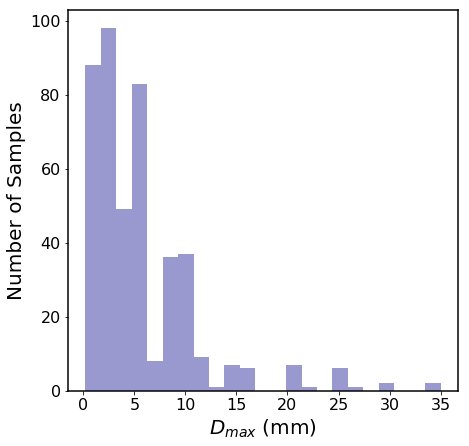

In [204]:
plt.figure()
ax = sns.distplot(CriticalD, hist=True, kde=False, color='darkblue')
ax.set_xlabel('$D_{max}$ (mm)')
ax.set_ylabel('Number of Samples')
plt.savefig('D_distribution.png', dpi=400)

In [19]:
# sns.heatmap(features.corr(), square=True, annot=True)

#### Data Shuffling and Splitting 

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, CriticalD, test_size = 0.00000001, random_state = 7353)


#### Random Forest Regression

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
rf = RandomForestRegressor(n_estimators = 800, min_samples_split=2, bootstrap=False, max_features = 'sqrt')
scores = cross_val_score(rf, features_scaled, CriticalD, scoring='r2', cv=10)
print(scores)
print('Average: %f' %scores.mean())
predicted = cross_val_predict(rf, features_scaled, CriticalD, cv=10)

[0.73257094 0.6525336  0.53026874 0.64184402 0.45723721 0.71208304
 0.72589569 0.69963908 0.60166544 0.64450908]
Average: 0.639825


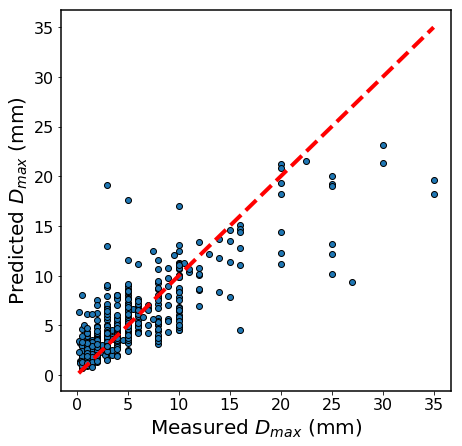

In [203]:
fig, ax = plt.subplots()
ax.scatter(CriticalD, predicted, edgecolors=(0, 0, 0))
ax.plot([CriticalD.min(), CriticalD.max()], [CriticalD.min(), CriticalD.max()], 'r--', lw=4)
ax.set_xlabel('Measured $D_{max}$ (mm)')
ax.set_ylabel('Predicted $D_{max}$ (mm)')
plt.savefig('measured_predicted.png', dpi=400)

In [21]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 400, stop = 1300, num = 10 )]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)


# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(features_scaled, CriticalD)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 3, 4, 5, 6], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True, False]}
Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed: 35.3min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [22]:
grid_search.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

In [60]:
best_grid = grid_search.best_estimator_

#### Plot the Feature Ranking

In [162]:
feature_rank = {k : v for k, v in zip(['Tg', 'Tx', 'Tl', 'TEN', 'VA', 'Delta', 'Entropy'], best_grid.feature_importances_)}
feature_rank_sorted = {key: value for key, value in sorted(feature_rank.items(), key=lambda kv: kv[1], reverse=True)}

In [163]:
feature_rank_sorted

{'Entropy': 0.16520726200829355,
 'Tx': 0.16328481585120574,
 'TEN': 0.15482376116219013,
 'Tl': 0.1526147644564995,
 '$T_g$': 0.14081602962356052,
 'VA': 0.12390660298069502,
 'Delta': 0.09934676391755554}

    Entropy        Tx       TEN        Tl     $T_g$        VA     Delta
0  0.165207  0.163285  0.154824  0.152615  0.140816  0.123907  0.099347


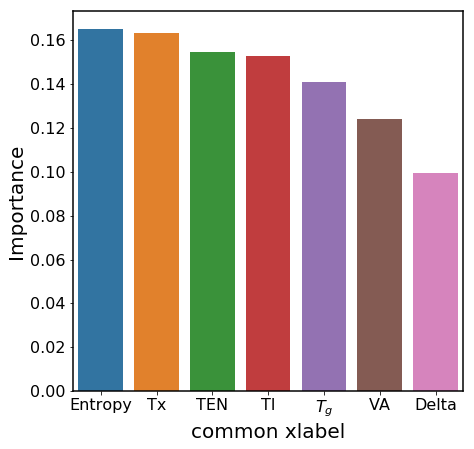

In [201]:
df_feature = pd.DataFrame.from_records([feature_rank_sorted],columns=feature_rank_sorted.keys())
print(df_feature)
plt.figure()
ax = sns.barplot(data=df_feature)
ax.set(ylabel='Importance')
plt.savefig('features_rank.png', dpi=400)

#### Recursive Feature Elimination 

In [85]:
from sklearn.feature_selection import RFECV

# Create the RFE object and cvc = SVC(kernel="linear")
rf = RandomForestRegressor(n_estimators = 800, min_samples_split=2, bootstrap=False, max_features = 'sqrt')
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=rf, step=1, cv=10, scoring='r2')
rfecv.fit(features_scaled, CriticalD)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores


Optimal number of features : 7


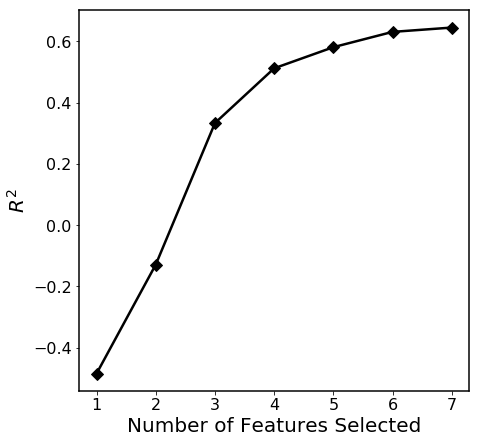

In [196]:
plt.figure()
plt.xlabel("Number of Features Selected")
plt.ylabel("$R^2$")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_+0.01,'k',lw=2.5, markersize=8, marker='D')
# plt.show()
plt.savefig('features_selection.png', bbox_inches = "tight", dpi=400)

#### K nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
reg = KneighborRegressor(n_neighbors=3)
model_run_evaluate(reg, X_train, X_test, y_train, y_test)

#### Neural Network 

In [ ]:
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor(hidden_layer_sizes = (12,), activation = 'relu', solver='lbfgs', ba)